In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from PCSpreadOLS import PCASpreadOLS

In [3]:
df_rtn = PCASpreadOLS().full_sample_ols()

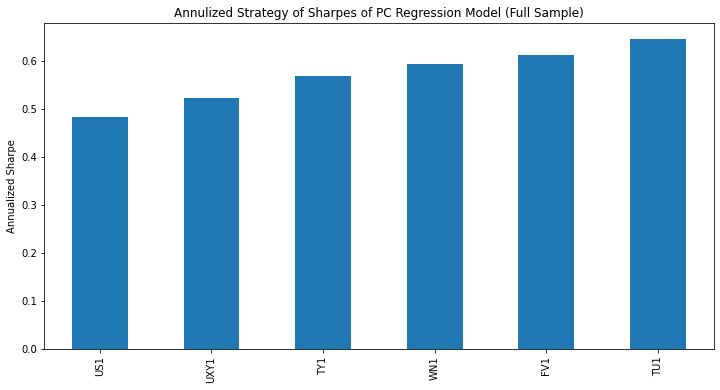

In [4]:
def plot_sharpe(df_rtn: pd.DataFrame) -> plt.Figure: 
    
    (df_rtn[
        ["security", "signal_rtn"]].
        groupby("security").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        sort_values("sharpe")
        [["sharpe"]].
        plot(
            kind    = "bar",
            legend  = False,
            title   = "Annulized Strategy of Sharpes of PC Regression Model (Full Sample)",
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            figsize = (12,6)))
    
plot_sharpe(df_rtn)

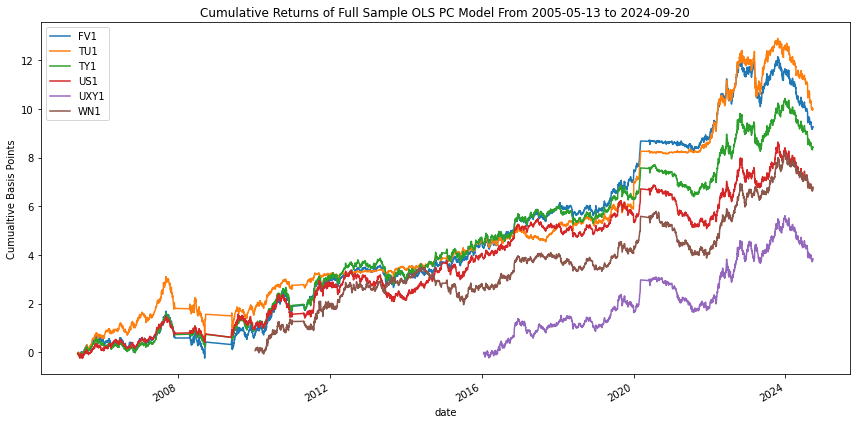

In [5]:
def plot_cumulative_rtn(df_rtn: pd.DataFrame) -> plt.Figure: 
    
    (df_rtn[
        ["date", "security", "signal_rtn"]].
        rename(columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        cumsum().
        plot(
            figsize = (12,6),
            ylabel = "Cumualtive Basis Points",
            title  = "Cumulative Returns of Full Sample OLS PC Model From {} to {}".format(
                df_rtn.date.min().date(),
                df_rtn.date.max().date())))

    plt.tight_layout()
    
plot_cumulative_rtn(df_rtn)

In [6]:
def get_erc(df_rtn: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_wider = (df_rtn[
        ["date", "signal_rtn", "security"]].
        pivot(index = "date", columns = "security", values = "signal_rtn").
        ewm(span = window, adjust = False).
        std().
        shift().
        apply(lambda x: 1 / x).
        reset_index().
        melt(id_vars = "date").
        dropna())

    df_cum = (df_wider.drop(
        columns = ["security"]).
        groupby("date").
        agg("sum").
        rename(columns = {"value": "cum_inv"}))

    df_port = (df_wider.merge(
        right = df_cum, how = "inner", on = ["date"]).
        assign(weight = lambda x: x.value / x.cum_inv).
        merge(right = df_rtn, how = "inner", on = ["date", "security"]).
        assign(weighted_rtn = lambda x: x.weight * x.signal_rtn)
        [["date", "weighted_rtn"]].
        groupby("date").
        agg("sum"))
    
    return df_port

df_port = get_erc(df_rtn)

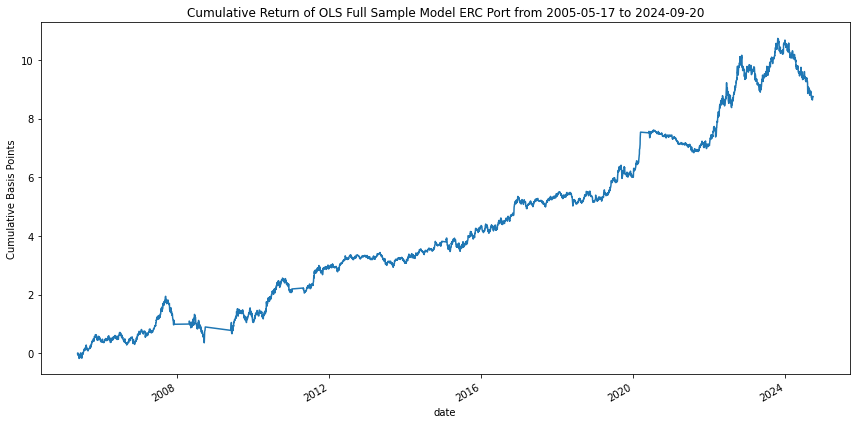

In [7]:
def plot_erc_port(df_port: pd.DataFrame) -> plt.Figure: 
    
    (df_port.cumsum().plot(
        ylabel  = "Cumulative Basis Points",
        legend  = False,
        figsize = (12,6),
        title   = "Cumulative Return of OLS Full Sample Model ERC Port from {} to {}".format(
            df_port.index.min().date(),
            df_port.index.max().date())))
    
    plt.tight_layout()
    
plot_erc_port(df_port)